## PPO performance analysis and deep dive

**Questions**
- What kind of scenes are hard to learn?
    - Properties (# agents), # intersections, etc...


**Procedure**
- Take a trained PPO model
- Evaluate model:
    - Single-agent mode (use policy to control a single-agent, the rest are expert-controlled)
    - Multi-agent mode (use policy to control all agents in the scene)

In [94]:
# Dependencies
import glob
import pandas as pd
import seaborn as sns
import numpy as np
from IPython.display import HTML, Image
import warnings
from nocturne.envs.base_env import BaseEnv
from pathlib import Path
from pyvirtualdisplay import Display
import torch
import imageio
import logging
import os
import matplotlib.pyplot as plt
from evaluation.policy_evaluation import evaluate_policy
from networks.perm_eq_late_fusion import LateFusionNet, LateFusionPolicy
from utils.plot import plot_agent_trajectory
from utils.config import load_config_nb
from utils.sb3.reg_ppo import RegularizedPPO

sns.set('notebook', font_scale=1.1, rc={'figure.figsize': (10, 5)})
sns.set_style('ticks', rc={'figure.facecolor': 'none', 'axes.facecolor': 'none'})
%config InlineBackend.figure_format = 'svg'
warnings.filterwarnings("ignore")
plt.set_loglevel('WARNING')

### Configurations 

In [64]:
MAX_FILES = 1000
DETERMINISTIC = True 
SELECT_FROM = 1000
NUM_EVAL_EPISODES = 1000
METRICS = ['goal_rate', 'off_road', 'veh_veh_collision']
VIDEO_PATH = '../evaluation/videos'

TRAIN_DATA_PATH = '../data_full/train'
TEST_DATA_PATH = '../data_full/valid'

# Load config files
env_config = load_config_nb("env_config")
exp_config = load_config_nb("exp_config")
video_config = load_config_nb("video_config")
model_config = load_config_nb("model_config")

# Set data path
env_config.num_files = MAX_FILES

# Logging level set to INFO
LOGGING_LEVEL = "INFO"

# Scenes on which to evaluate the models
# Make sure file order is fixed
train_file_paths = glob.glob(f"{env_config.data_path}" + "/tfrecord*")
train_eval_files = sorted([os.path.basename(file) for file in train_file_paths])

### Helper functions 

In [6]:
def create_video(image_array, filename, *, fps=4, loop=500):
    with imageio.get_writer(filename, duration=1_000 / fps, loop=loop) as writer:
        for img in image_array:
            img = np.moveaxis(img, [0, 1, 2], [2, 0, 1])
            writer.append_data(img)


def display_gif(filename, width=500, height=500):
    display(
        Image(
            data=open(filename, "rb").read(), format="gif", width=width, height=height
        )
    )

### Load trained PPO policy

In [7]:
RL_BASE_PATH = f"../models/hr_rl/S{MAX_FILES}"
POLICY_NAME = 'policy_L0.0_S1000_I606'
rl_policy = RegularizedPPO.load(f'{RL_BASE_PATH}/{POLICY_NAME}')

INFO:root:No regularization weight specified, using default PPO.


## 1. Aggregate performance

### 1.1 Single-agent mode | **train**

In [8]:
df_res_sa_train = evaluate_policy(
    env_config=env_config,
    controlled_agents=1,
    data_path=TRAIN_DATA_PATH,
    mode='policy',
    policy=rl_policy,
    select_from_k_scenes=SELECT_FROM,
    num_episodes=NUM_EVAL_EPISODES,
)

df_res_sa_train['Class'] = 'SA_train'

100%|██████████| 1000/1000 [01:11<00:00, 14.07it/s]


In [9]:
df_res_sa_train[METRICS].mean() * 100

goal_rate            73.8
off_road              4.4
veh_veh_collision    23.6
dtype: float64

### 1.2 Single-agent mode | **test**

In [10]:
df_res_sa_test = evaluate_policy(
    env_config=env_config,
    controlled_agents=1,
    data_path=TEST_DATA_PATH,
    mode='policy',
    policy=rl_policy,
    select_from_k_scenes=SELECT_FROM,
    num_episodes=NUM_EVAL_EPISODES,
)

df_res_sa_test['Class'] = 'SA_test'

100%|██████████| 1000/1000 [01:07<00:00, 14.89it/s]


In [11]:
df_res_sa_test[METRICS].mean() * 100

goal_rate            74.7
off_road              3.9
veh_veh_collision    22.0
dtype: float64

### 1.3 Multi-agent mode | **train**

In [81]:
df_res_ma_train = evaluate_policy(
    env_config=env_config,
    controlled_agents=20,
    data_path=TRAIN_DATA_PATH,
    mode='policy',
    policy=rl_policy,
    select_from_k_scenes=SELECT_FROM,
    num_episodes=NUM_EVAL_EPISODES,
)

df_res_ma_train['Class'] = 'MA_train'

100%|██████████| 1000/1000 [04:21<00:00,  3.82it/s]


In [86]:
df_res_ma_train[METRICS].mean() * 100

goal_rate            82.669553
off_road              4.444444
veh_veh_collision    13.679654
dtype: float64

### 1.4 Multi-agent mode | **test**

In [14]:
df_res_ma_test = evaluate_policy(
    env_config=env_config,
    controlled_agents=20,
    data_path=TEST_DATA_PATH,
    mode='policy',
    policy=rl_policy,
    select_from_k_scenes=SELECT_FROM,
    num_episodes=NUM_EVAL_EPISODES,
)

df_res_ma_test['Class'] = 'MA_test'

  5%|▍         | 47/1000 [00:10<04:46,  3.33it/s]

100%|██████████| 1000/1000 [03:39<00:00,  4.57it/s]


In [15]:
df_res_ma_test[METRICS].mean() * 100

goal_rate            84.811432
off_road              4.110194
veh_veh_collision    11.785504
dtype: float64

## 2. Properties of hard scenes

In [16]:
df_all = pd.concat([df_res_sa_train, df_res_sa_test, df_res_ma_train, df_res_ma_test])

In [24]:
df_all.groupby('Class')[METRICS].mean().round(2) * 100

,goal_rate,off_road,veh_veh_collision
Class,,,
MA_test,85.0,4.0,12.0
MA_train,83.0,5.0,13.0
SA_test,75.0,4.0,22.0
SA_train,74.0,4.0,24.0


In [26]:
#print((df_all.groupby('Class')[METRICS].mean().round(2) * 100).to_latex())

In [79]:
df_res_ma_train.scene_id.unique().shape

(626,)

In [107]:
# Group by scene and sort by goal rate
df_res_ma_train.groupby('scene_id')[METRICS + ['veh_id']].mean().sort_values('goal_rate', ascending=True)#.style

,goal_rate,off_road,veh_veh_collision,veh_id
scene_id,,,,
tfrecord-00973-of-01000_217.json,0.0,0.0,1.0,11.75
tfrecord-00634-of-01000_261.json,0.0,0.0,1.0,8.5
tfrecord-00579-of-01000_342.json,0.0,1.0,0.0,4.0
tfrecord-00115-of-01000_217.json,0.0,0.0,1.0,26.666667
tfrecord-00728-of-01000_135.json,0.0,0.0,1.0,54.5
...,...,...,...,...
tfrecord-00483-of-01000_16.json,1.0,0.0,0.0,12.5
tfrecord-00582-of-01000_459.json,1.0,0.0,0.0,6.666667
tfrecord-00013-of-01000_405.json,1.0,0.2,0.0,2.8


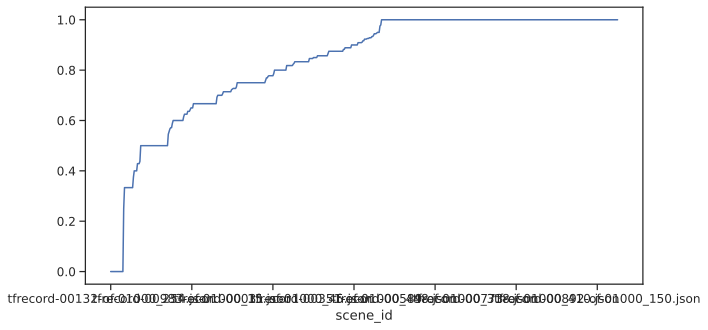

In [54]:
df_res_ma_train.groupby('scene_id')[METRICS + ['veh_id']].mean().sort_values('goal_rate', ascending=True)['goal_rate'].plot();

In [116]:
np.linspace(-1.5, 1.5, 11)

array([-1.5, -1.2, -0.9, -0.6, -0.3,  0. ,  0.3,  0.6,  0.9,  1.2,  1.5])

## 3. Render

In [108]:
SCENE_NAME = "tfrecord-00848-of-01000_137.json"

env_config.data_path = TRAIN_DATA_PATH
env = BaseEnv(env_config)

In [109]:
pos_arr = np.zeros((80, 2))
speed_arr = np.zeros((80))
steering_arr = np.zeros(80)
action_acc = np.zeros(80)
action_ste = np.zeros(80)

obs_dict = env.reset(filename=SCENE_NAME)
frames = []

for time_step in range(80):
    
    action_dict = {}
    for agent_id in obs_dict:
        # Get observation
        obs = torch.from_numpy(obs_dict[agent_id]).unsqueeze(dim=0)

        # Get action
        action, _ = rl_policy.predict(obs, deterministic=True)
        action_dict[agent_id] = int(action)

    
    if time_step % 4 == 0:
        with Display(backend="xvfb") as disp:
            render_scene = env.scenario.getImage(**video_config.render)
            frames.append(render_scene.T)

    # Step
    obs_dict, rew_dict, done_dict, info_dict = env.step(action_dict)
    
    if done_dict['__all__']:
        break

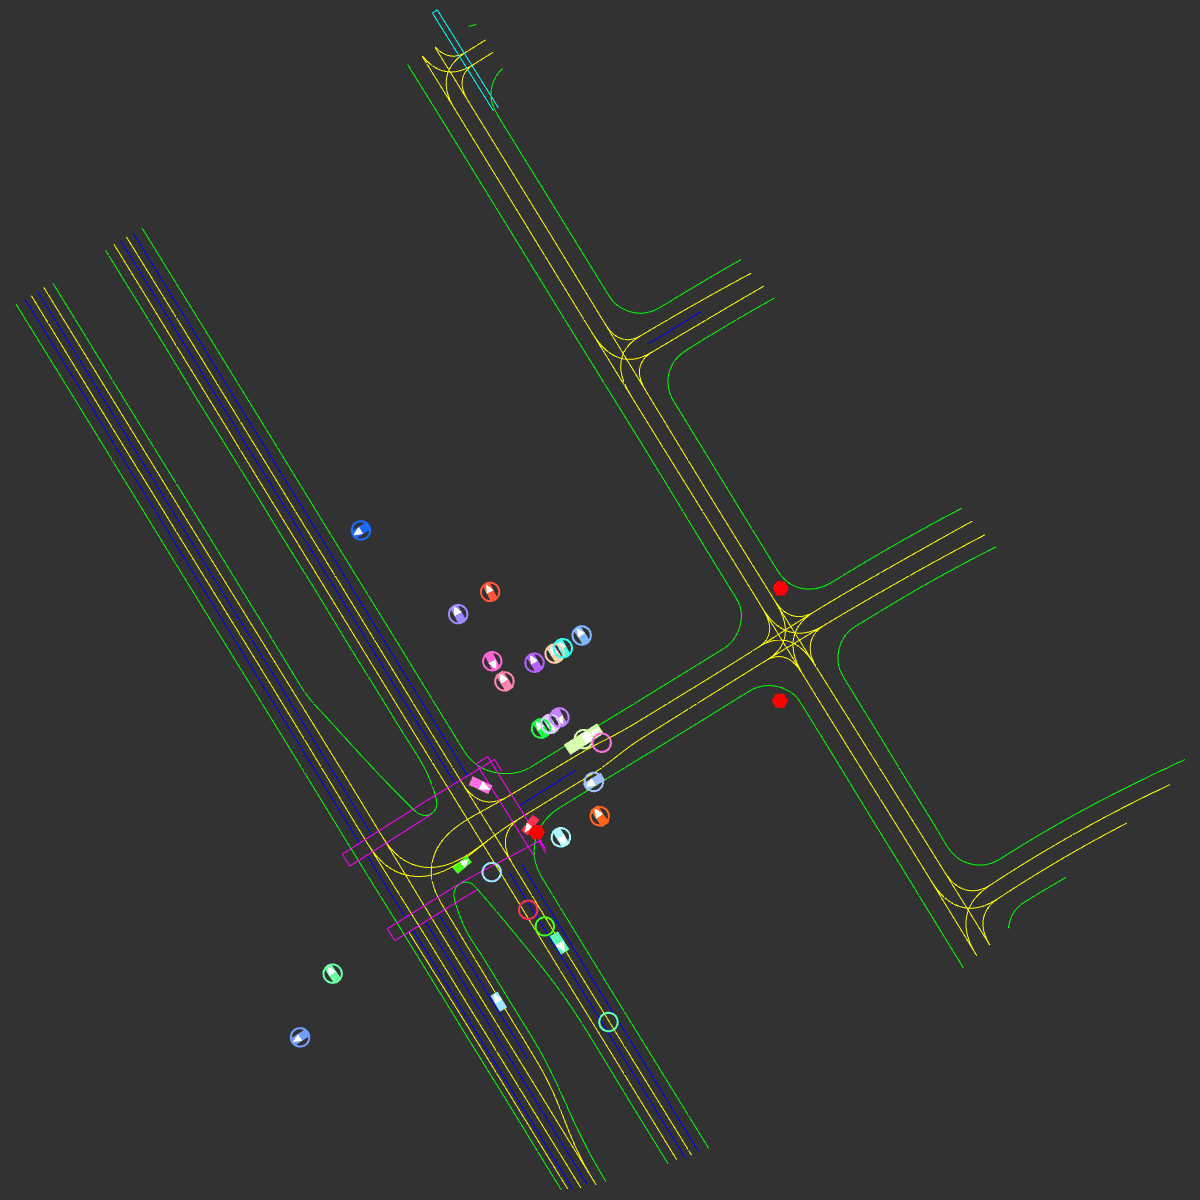

In [112]:
Path(f"{VIDEO_PATH}/{SCENE_NAME}").parent.mkdir(parents=True, exist_ok=True)
create_video(frames, f"{VIDEO_PATH}/{SCENE_NAME}.gif", fps=2)
display(HTML(f"<h3>{SCENE_NAME}</h3>"))
display_gif(f"{VIDEO_PATH}/{SCENE_NAME}.gif")

## 4. Trajectories